#### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline


env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
import tifffile as tiff
import shapely.wkt
import geopandas as gpd
import numpy as np
import cv2
from joblib import Parallel, delayed
from functools import partial

In [3]:
data_dir = Path("/media/wwymak/Storage/spacenet_roads")

In [4]:
import solaris as sol
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union


#### data --files

In [5]:
train_dir = data_dir / "AOI_3_Paris_Roads_Train"
train_dir.ls()

[PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/masks'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/RGB-PanSharpen'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/MUL-PanSharpen'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/MUL'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/summaryData'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/PAN'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/rgb_256'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/geojson'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/mask_256')]

In [6]:
(train_dir / "geojson" / "spacenetroads").ls()[:5]

[PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/geojson/spacenetroads/spacenetroads_AOI_3_Paris_img75.geojson'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/geojson/spacenetroads/spacenetroads_AOI_3_Paris_img414.geojson'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/geojson/spacenetroads/spacenetroads_AOI_3_Paris_img11.geojson'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/geojson/spacenetroads/spacenetroads_AOI_3_Paris_img47.geojson'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/geojson/spacenetroads/spacenetroads_AOI_3_Paris_img393.geojson')]

In [7]:
(train_dir / "RGB-PanSharpen").ls()[:5]

[PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img359.tif'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img268.tif'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img173.tif'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img160.tif'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img28.tif')]

#### dataviewing

In [8]:
def scale_percentile(matrix):
    # scale tiff files read by tifffile to an rgb format readable by e.g. mpl for display
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix

In [9]:
def plot_mask_img(img_id, road_mask_width=4):
    mask_fname = train_dir / "geojson" / "spacenetroads"/f"spacenetroads_{img_id}.geojson"
    
    try:
        road_mask = sol.vector.mask.road_mask(str(mask_fname),
                                              reference_im=str(train_dir /"RGB-PanSharpen" / f"RGB-PanSharpen_{img_id}.tif"),
                                              width=road_mask_width, meters=True)

    except Exception as e:
        return
    f = plt.figure(figsize=(10,6))
    plt.subplot(121)
    img_rgb = tiff.imread(str(train_dir /"RGB-PanSharpen" / f"RGB-PanSharpen_{img_id}.tif"))

    tiff.imshow(255 * scale_percentile(img_rgb), figure=f, subplot=121);
    plt.subplot(122)
    plt.imshow(road_mask, cmap='gray');

In [10]:
summary_data = pd.read_csv("/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/summaryData/AOI_3_Paris_Roads_Train.csv")


/home/wwymak/anaconda3/envs/solaris/lib/python3.6/site-packages/tifffile/tifffile.py:11725: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  subplot = pyplot.subplot(subplot)


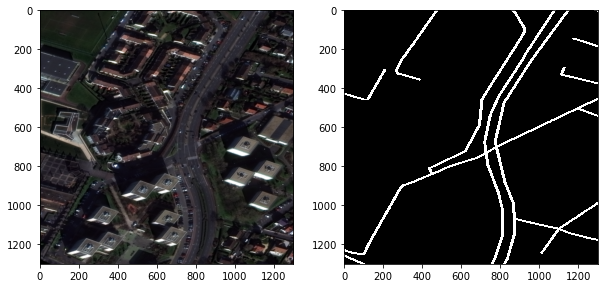

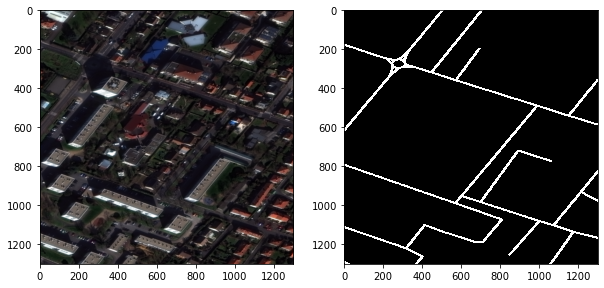

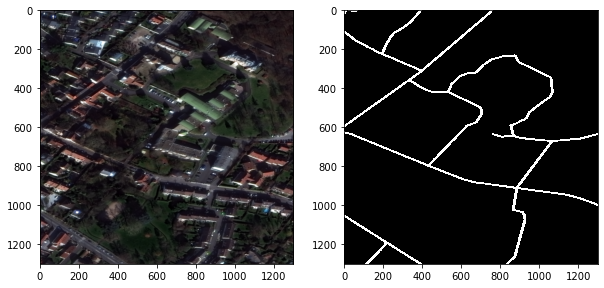

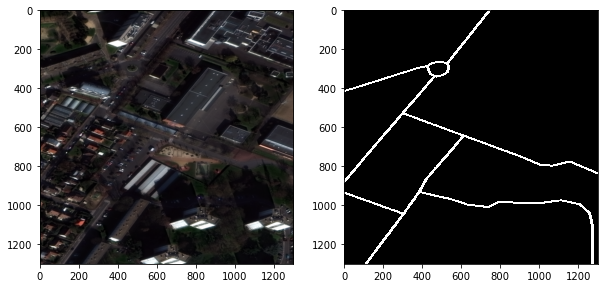

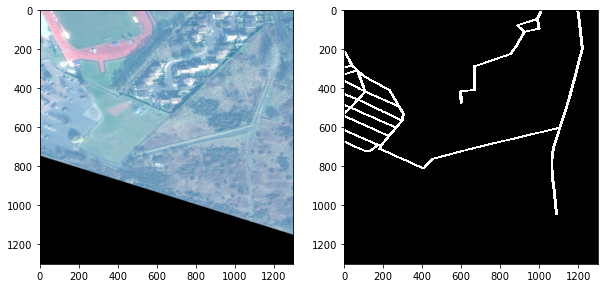

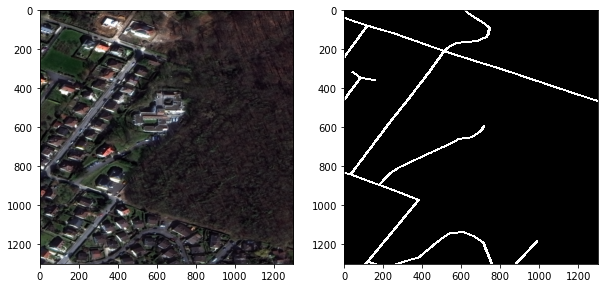

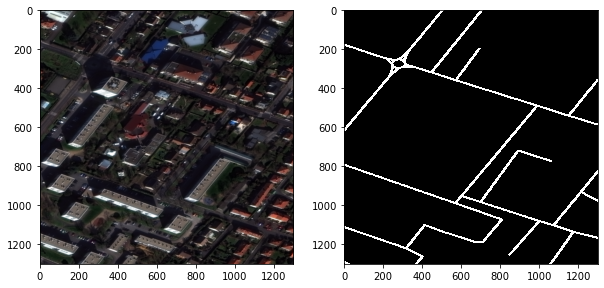

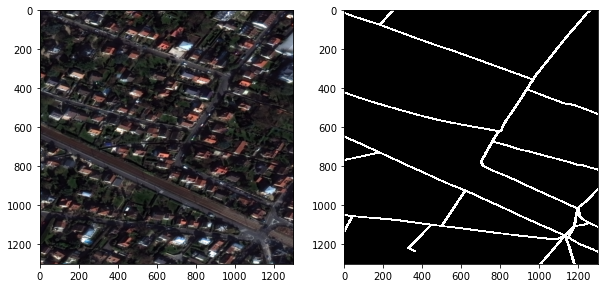

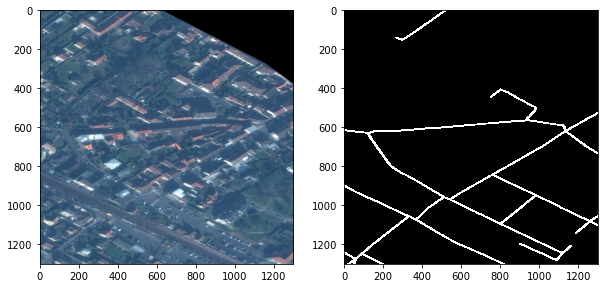

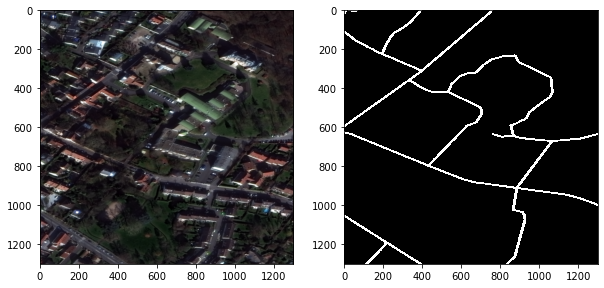

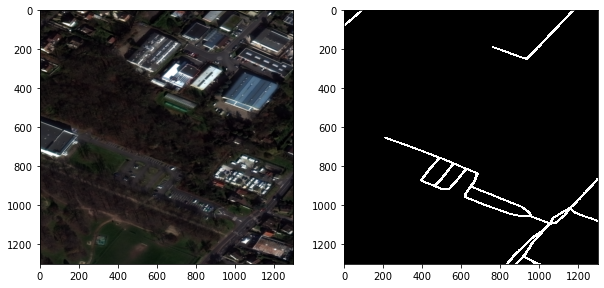

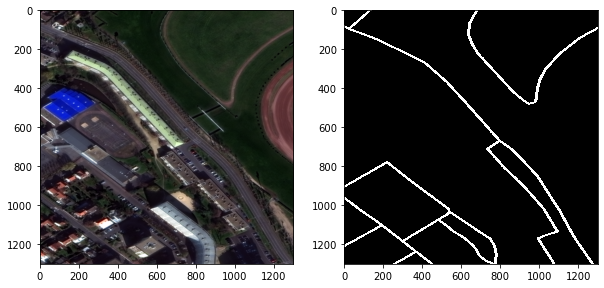

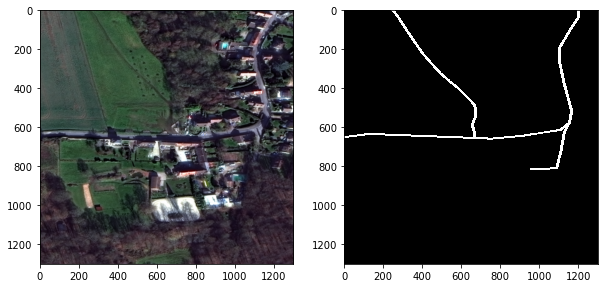

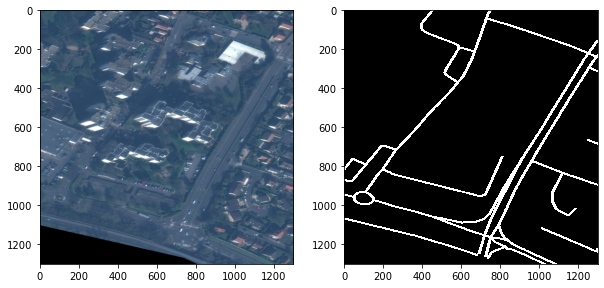

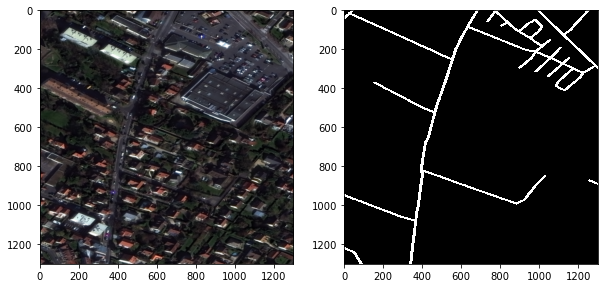

In [11]:
img_ids =  np.random.choice(summary_data.ImageId, 20, replace=False)
[plot_mask_img(img_id,3) for img_id in img_ids];

as nvidia mentioned in their blog post, it's quite hard to get an accurate segmentation mask for roads using linestrings. They use cv2.floodfill in their label creation to get a truer representation 

In [15]:
def plot_mask_img2(img_id, road_mask_width=5, loDiff=30, upDiff=30):
    mask_fname = train_dir / "geojson" / "spacenetroads"/f"spacenetroads_{img_id}.geojson"
    img_rgb = tiff.imread(str(train_dir /"RGB-PanSharpen" / f"RGB-PanSharpen_{img_id}.tif"))

    img_rgb = (255 * scale_percentile(img_rgb)).astype(np.uint8)
    h, w, d = img_rgb.shape
    
    try:
        road_mask = sol.vector.mask.road_mask(str(mask_fname),
              reference_im=str(train_dir /"RGB-PanSharpen" / f"RGB-PanSharpen_{img_id}.tif"),
              width=road_mask_width, meters=True, burn_value=1)
        road_mask = skimage.morphology.thin(road_mask, max_iter=5)
        
    except Exception as e:
        print(e)
        return
    
    mask = np.zeros((h+2,w+2),np.uint8)
    for x, y  in np.argwhere(road_mask == 1):
        num,img_rgb,mask,rect = cv2.floodFill(img_rgb, mask, 
                                         seedPoint=(y, x),newVal=255, loDiff=[loDiff,]*3,
                                              upDiff=[upDiff,] * 3, flags=cv2.FLOODFILL_MASK_ONLY)

    # f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    f = plt.figure(figsize=(12,6))
    plt.subplot(121)
    

    tiff.imshow(255 * scale_percentile(img_rgb), figure=f, subplot=131);
    plt.subplot(132)
    plt.imshow(road_mask, cmap='gray');
    
    plt.subplot(133)
    plt.imshow(mask, cmap='gray');

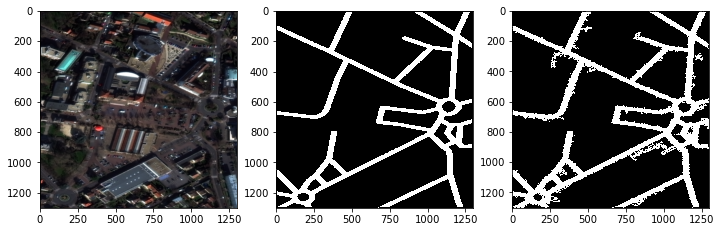

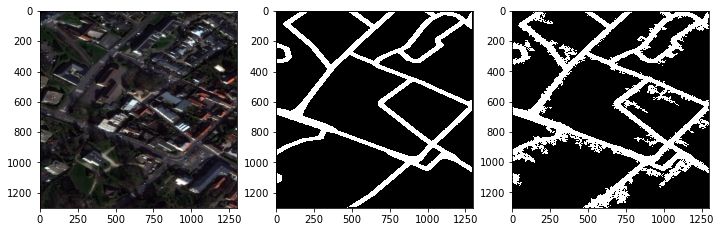

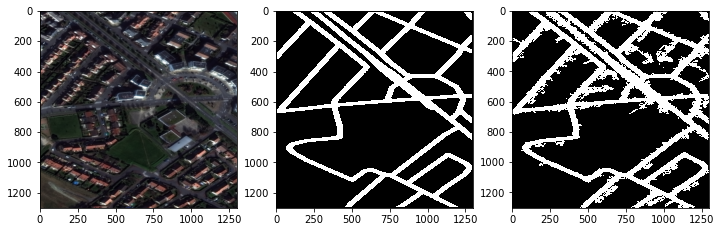

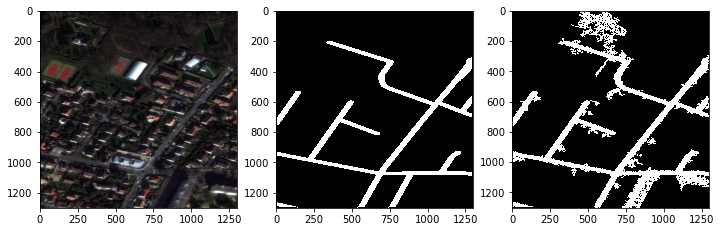

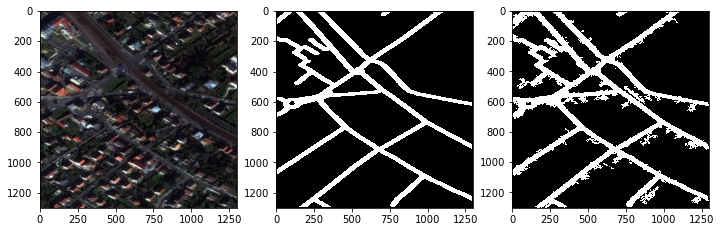

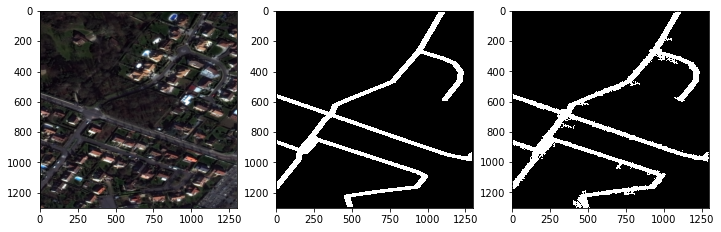

In [17]:
img_ids =  np.random.choice(summary_data.ImageId, 6, replace=False)
[plot_mask_img2(img_id,10, loDiff=3, upDiff=3) for img_id in img_ids];

~~Unfortunately, the floodfill doesn't seem to have worked particulary well on the RGB pansharpened images...
Let's stick with the simpler solution of going with a fixed line width for image segmentation for now.~~

Using skimage.morphology.thin seems to have helped some. Let's try again with the floodfill mask to see if it helps

Another thing to note is that the images are large (1300 by 1300 pix)-- it might be better to divide them up into e.g multiple images for training to avoid any memory issues

#### Todo tasks

tasks:
- [x] save the masks (road width 3 to a separate folder)
- [ ] write a dataloader for images/ masks divided up-- either preprocess it or do it dynamically...
- [ ] fastai unet learning for segmentation
- [ ] convert probability to road linestrings

####  Mask creation

In [18]:
mask_folder = train_dir / "masks"
mask_folder.mkdir(exist_ok=True)

In [41]:
def create_mask(img_id, road_mask_width=8):
    mask_fname = train_dir / "geojson" / "spacenetroads"/f"spacenetroads_{img_id}.geojson"
    outfile = mask_folder / f"mask_{img_id}.png"
    road_mask = np.zeros((1300,1300))
    try:
        road_mask = sol.vector.mask.road_mask(str(mask_fname),
              reference_im=str(train_dir /"RGB-PanSharpen" / f"RGB-PanSharpen_{img_id}.tif"),
              width=road_mask_width, meters=False, burn_value=1)
       
        
    except Exception as e:
        pass
    skimage.io.imsave(outfile, road_mask )
#     PIL.Image.fromarray(road_mask, mode='L').save(outfile);

In [20]:
def create_mask_with_floodfill(img_id, road_mask_width=3, loDiff=3, upDiff=3):
    mask_fname = train_dir / "geojson" / "spacenetroads"/f"spacenetroads_{img_id}.geojson"
    outfile = mask_folder / f"mask_{img_id}.png"
    road_mask = np.zeros((1300,1300))
    img_rgb = tiff.imread(str(train_dir /"RGB-PanSharpen" / f"RGB-PanSharpen_{img_id}.tif"))
    img_rgb = (255 * scale_percentile(img_rgb)).astype(np.uint8)
    h, w, d = img_rgb.shape
    
    try:
        road_mask = sol.vector.mask.road_mask(str(mask_fname),
              reference_im=str(train_dir /"RGB-PanSharpen" / f"RGB-PanSharpen_{img_id}.tif"),
              width=road_mask_width, meters=True, burn_value=1)
       
        
    except Exception as e:
        pass
    mask = np.zeros((h+2,w+2),np.uint8)
    for x, y  in np.argwhere(road_mask == 1):
        num,img_rgb,mask,rect = cv2.floodFill(img_rgb, mask, 
                                         seedPoint=(y, x),newVal=1, loDiff=[loDiff,]*3,
                                              upDiff=[upDiff,] * 3, flags=cv2.FLOODFILL_MASK_ONLY)
    skimage.io.imsave(outfile, mask )
#     PIL.Image.fromarray(road_mask, mode='L').save(outfile);

##### sanity check on 1 file:

In [46]:
create_mask(summary_data.ImageId[10], road_mask_width=20)

In [47]:
a = np.array(PIL.Image.open(mask_folder / f"mask_{summary_data.ImageId[10]}.png"))
a.min(), a.max(), np.unique(a)

(0, 1, array([0, 1], dtype=uint8))

In [48]:
a.shape

(1300, 1300)

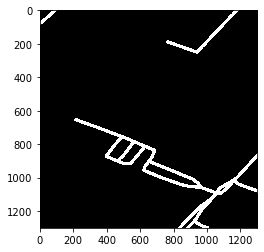

In [49]:
plt.imshow(np.array(PIL.Image.open(mask_folder / f"mask_{summary_data.ImageId[10]}.png")), cmap='gray')

0 1 [0 1]


/home/wwymak/anaconda3/envs/solaris/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/masks/mask_AOI_3_Paris_img362.png is a low contrast image
  warn('%s is a low contrast image' % fname)


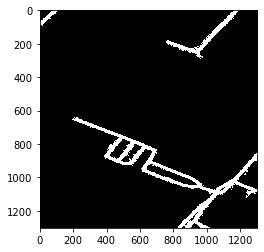

In [21]:
create_mask_with_floodfill(summary_data.ImageId[10], road_mask_width=5, loDiff=2, upDiff=2)
a = np.array(PIL.Image.open(mask_folder / f"mask_{summary_data.ImageId[10]}.png"))
print(a.min(), a.max(), np.unique(a))
plt.imshow(np.array(PIL.Image.open(mask_folder / f"mask_{summary_data.ImageId[10]}.png")), cmap='gray')

##### do the whole lot

In [50]:
# %time Parallel(n_jobs=28)(delayed(create_mask)(img_id) for img_id in summary_data.ImageId.unique());

%time Parallel(n_jobs=28)(delayed(partial(create_mask, road_mask_width=5))(img_id) for img_id in summary_data.ImageId.unique());

CPU times: user 1.68 s, sys: 664 ms, total: 2.34 s
Wall time: 10.5 s


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [23]:
len(mask_folder.ls()), len((train_dir/"RGB-PanSharpen").ls()), len((train_dir/"MUL-PanSharpen").ls())

(310, 310, 310)

#### Create dataset for DL

In [24]:
rgb_256 = train_dir / "rgb_256"
rgb_256.mkdir(exist_ok=True)

mask_256 = train_dir / "mask_256"
mask_256.mkdir(exist_ok=True)

In [25]:
def create_small_tiles(img_id, save_dir_rgb, save_dir_mask, new_img_height=256):
    img_rgb = tiff.imread(str(train_dir /"RGB-PanSharpen" / f"RGB-PanSharpen_{img_id}.tif"))
    img_rgb = (255 * scale_percentile(img_rgb)).astype(np.uint8)
    
    mask = np.array(PIL.Image.open(mask_folder / f"mask_{img_id}.png"))
    
    v = np.vsplit(img_rgb, np.arange(new_img_height, 1300, new_img_height))
    h = [np.hsplit(vert, np.arange(new_img_height, 1300, new_img_height)) for vert in v]
    
    v_mask = np.vsplit(mask, np.arange(new_img_height, 1300, new_img_height))
    h_mask = [np.hsplit(vert, np.arange(new_img_height, 1300, new_img_height)) for vert in v_mask]
    
    for idx_row, row in enumerate(h):
        for idx, item in enumerate(row):
            if item.shape[0] < 128 or item.shape[1] < 128:
                continue
            skimage.io.imsave(save_dir_rgb / f"rgb_256_{img_id}_{idx_row}_{idx}.tif", item)
#             im = PIL.Image.fromarray(item)
#             im.save(save_dir_rgb / f"rgb_256_{img_id}_{idx_row}_{idx}.tif")
            curr_mask = h_mask[idx_row][idx]
            skimage.io.imsave(save_dir_mask / f"mask_256_{img_id}_{idx_row}_{idx}.png", curr_mask)
#             PIL.Image.fromarray(curr_mask).save(save_dir_mask / f"mask_256_{img_id}_{idx_row}_{idx}.jpg")
        



In [51]:
tiler = partial(create_small_tiles, save_dir_rgb=rgb_256, save_dir_mask=mask_256, new_img_height=256)
%time Parallel(n_jobs=28)(delayed(tiler)(img_id) for img_id in summary_data.ImageId.unique());
# [create_small_tiles(id, rgb_256, mask_256, new_img_height=256) for id in summary_data.ImageId]

CPU times: user 4.14 s, sys: 75.4 ms, total: 4.22 s
Wall time: 26.7 s


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [29]:
len(rgb_256.ls()), len(mask_256.ls())

(7751, 7750)

In [59]:
fname = np.random.choice(mask_256.ls(), 1)

mask = open_mask(fname[0])
mask.show(figsize=(5,5), alpha=1)fpath

#### Metrics

We need good metrics for monitoring the neural net training-- for simple segmentation, the pixel accuracy might be a good starting point, but this is not a good reflection for this task since we are more interested in detecting the shape of the road rather than all the pixels of it.

The IoU score might be an easy first start-- have to figure out how to implement the APLS (https://github.com/CosmiQ/apls) score into it though...

In [60]:
def get_mask_fn(fname):
    return mask_256 / fname.name.replace("rgb", "mask").replace("tif", "png")
codes = np.array(["void", "road"])
src = (SegmentationItemList.from_folder(rgb_256)
       .split_by_rand_pct(0.2, seed=42)
       .label_from_func(get_mask_fn, classes=codes)
      )

In [61]:
batch_size = 8
size=128
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = (src
        .transform(tfms, tfm_y=True, size=size)
        .databunch(bs=batch_size)
        .normalize(imagenet_stats))

In [62]:
data.show_batch(18, figsize=(10,7))

In [1]:
(data.train_ds.x[10])

NameError: name 'data' is not defined

In [24]:
wd = 1e-2
learn = unet_learner(data, models.resnet34, metrics=[partial(dice, iou=True),
                             partial(foreground_acc, void_code=0)], wd=wd, bottle=True)

Min numerical gradient: 2.51E-05
Min loss divided by 10: 3.31E-03


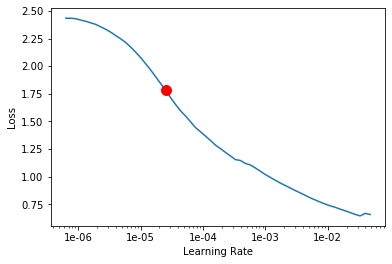

In [28]:
learn.lr_find()
learn.recorder.plot(suggestion=True, skip_end=1)

In [29]:
lr = 5e-2
learn.fit_one_cycle(2, slice(lr), pct_start=0.8)

In [30]:
learn.fit_one_cycle(2, slice(lr))

In [45]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True,)


Min numerical gradient: 3.31E-06
Min loss divided by 10: 5.25E-04


In [47]:
lr = 1e-3
lrs = slice(lr/100,lr)

learn.fit_one_cycle(5, lrs)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.09E-02


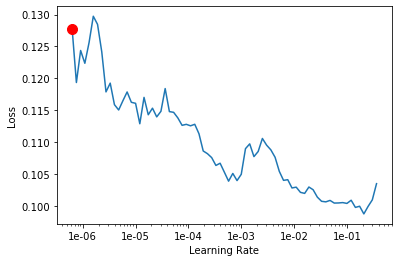

In [48]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [49]:
lr = 1e-3
lrs = slice(lr/100,lr)

learn.fit_one_cycle(10, lrs)

In [40]:
def plot_mask_img_fastai(data):
    img_fnames = data.items
    mask_fnames = data.y.items
    
    print(len(img_fnames))
    
    for img_filename, mask_filename in zip (img_fnames, mask_fnames):
        f = plt.figure(figsize=(10,6))
        plt.subplot(121)
        img_rgb = np.array(PIL.Image.open(img_filename))
        plt.imshow(img_rgb)

        
        plt.subplot(122)
        plt.imshow(np.array(PIL.Image.open(mask_filename)), cmap='gray');

In [ ]:
img_fnames = data.items
mask_fnames = data.y.items

print(len(img_fnames))